In [2]:
from __future__ import unicode_literals, division
import numpy as np
from skimage import io, color
import torch
import torch.nn.functional as F
import torch.nn as nn
import cv2
from torch.autograd import Variable
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from torch import nn
from torchvision import transforms, datasets
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import ImageFilter

#global variable

cuda = torch.cuda.is_available()
di = '/home/kamata/neo/datasets'
BATCH =4
LR = 0.0001 #????

SyntaxError: from __future__ imports must occur at the beginning of the file (<ipython-input-2-5fa72ccc51d0>, line 5)

In [2]:
data_transform = transforms.Compose([
        #transforms.Scale(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406],
         #                        std=[0.229, 0.224, 0.225])
    ])
data_transform2 = transforms.Compose([
        #transforms.Scale(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        
    ])
hymenoptera_dataset1 = datasets.ImageFolder(root='/home/kamata/linda/0508/train-urban/rgb',
                                           transform=data_transform)
dataset_loader1 = torch.utils.data.DataLoader(hymenoptera_dataset1,
                                             batch_size=BATCH, shuffle=False,
                                             num_workers=2)
hymenoptera_dataset2 = datasets.ImageFolder(root='/home/kamata/linda/0508/train-urban/nir', #infared
                                           transform=data_transform)
dataset_loader2 = torch.utils.data.DataLoader(hymenoptera_dataset2,
                                             batch_size=BATCH, shuffle=False,
                                             num_workers=2)


In [3]:
import ColorNet
from ColorNet import ColorNet
net2=ColorNet()
net2=net2.cuda()

In [4]:
print net2


ColorNet(
  (g): UNet(
    (inc): inconv(
      (conv): double_conv(
        (conv): Sequential(
          (0): Conv2d (1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
          (2): ReLU(inplace)
          (3): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
          (5): ReLU(inplace)
        )
      )
    )
    (down1): down(
      (mpconv): Sequential(
        (0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
        (1): double_conv(
          (conv): Sequential(
            (0): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
            (2): ReLU(inplace)
            (3): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tr

In [10]:
net2.load_state_dict(torch.load('/home/kamata/linda/0114unetedge/0122last/dloss3/350.pkl'))



In [4]:
t0 = transforms.Compose([transforms.ToTensor(),
                        ])
t1 = transforms.Compose([transforms.ToPILImage(),
                        ])
costs2 = []
epoch = 0
optim2 = torch.optim.Adam( net2.parameters() ,0.0001) 

#net = net.cuda()
def train(epoch):
    i=0
    j=0
    costs2=[]
    net2.train()
    d1 = enumerate(dataset_loader1)
    d2 = enumerate(dataset_loader2)
    global da1, da2
    #print(len(dataset_loader1))
    for i in range(len(dataset_loader1)):
        data1 = d1.next()
        data2 = d2.next()
        da0 = data1[1][0]
        da2 = data2[1][0]
        da3 = da0.clone()
        optim2.zero_grad() 
#uv=rgb here
        for j in range(len(da3)):
            da1=da3[j]
            da1 = t1(da1)
            da1 = da1.filter(ImageFilter.FIND_EDGES)
            da1 = t0(da1)
            da1 = da1
            da3[j]=da1
        da3 = da3.cuda()
        da0 = da0.cuda()
        da2 = da2.cuda()
        da0 = Variable(da0, requires_grad = False)
        da2 = Variable(da2[:,0:1,:,:], requires_grad = False)
        da3 = Variable(da3[:,0:1,:,:], requires_grad = False)
        preuv, rgb = net2(da2,da0)
        cost1 = F.mse_loss(rgb,da0)
        cost2 = F.mse_loss(preuv,da3)
        #cost2 = torch.mean(preuv.pow(2))
        cost = cost1 + cost2
        
        cost.backward()
     
        optim2.step()
        
        if i % 10 ==0:
            print cost.data.cpu()[0], i, epoch,
        costs2.append(cost.data.cpu()[0])
        
    return  costs2


In [ ]:
epoch=0
for j in xrange(400):
    costs2x = train(epoch)
    costs2 = costs2 + costs2x
    if epoch %100 ==0:
        torch.save(net2.state_dict(), '/home/kamata/linda/0508/dloss3/'+str(epoch)+'urban.pkl')

    epoch = epoch +1




/home/kamata/anaconda2/lib/python2.7/site-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


0.559758782387 0 0 0.261163115501 10 0 0.102733276784 20 0 0.594549417496 30 0 0.060932032764 40 0 0.128390833735 50 0 0.172943562269 60 0 0.138130396605 70 0 0.0912401378155 80 0 0.116900280118 90 0 0.23582059145 100 0 0.243426978588 110 0 0.0784015282989 120 0 0.112772285938 130 0 0.0725942105055 140 0 0.0709855258465 150 0 0.0315220206976 160 0 0.0602081865072 170 0 0.078756339848 180 0 0.145837843418 190 0 0.0464199930429 200 0 0.0590905025601 210 0 0.137865871191 220 0 0.0354902558029 230 0 0.0444700345397 240 0 0.0492733195424 250 0 0.136439174414 260 0 0.0201042257249 270 0 0.0553046315908 280 0 0.0946682468057 290 0 0.0655031949282 300 0 0.0259171761572 310 0 0.0195301286876 320 0 0.03182663396 330 0 0.0896364152431 340 0 0.0705878138542 350 0 0.0411387607455 360 0 0.0514522641897 370 0 0.0522067062557 380 0 0.0401207879186 390 0 0.0563220903277 0 1 0.0410456135869 10 1 0.0226256810129 20 1 0.253843665123 30 1 0.0372150242329 40 1 0.0312695167959 50 1 0.0707017630339 60 1 0.042

In [ ]:
torch.save(net2.state_dict(), '/home/kamata/linda/0508/dloss3/400urban-final.pkl')
import matplotlib.pyplot as plt

plt.plot( costs2)
plt.show()
#plt.savefig('cost-bn-512resultD+E.jpg')

In [7]:
t0 = transforms.Compose([transforms.ToTensor(),
                        ])
t1 = transforms.Compose([transforms.ToPILImage(),
                        ])
t2 = lambda x: x.transpose(Image.FLIP_LEFT_RIGHT)
t3 = lambda x: t0(t2(x))

#print(Variable(pic, requires_grad = False))
#net2.eval()
#netD.eval()
#pic=color.rgb2lab(t1(pic.squeeze().cpu()))
#torch.save(net2.state_dict(), '/home/kamata/linda/0114unetedge/0122last/dloss2/400.pkl')

In [14]:

def saveresult(i,a):
    picI = hymenoptera_dataset4[a][0]
    picC = hymenoptera_dataset3[a][0]
    inn = picI[0:1,:,:]
    inp = net2.g(Variable(inn.unsqueeze(0).cuda()))
    pic = t1(picC)
    #pic = pic.filter(ImageFilter.FIND_EDGES)
    plt.figure('data', figsize=(12,4))
    plt.subplot(1,4,1)
    plt.title('Fig.1 Input-infrared')
    imshow(t1(picI))
    plt.subplot(1,4,3)
    plt.title('Fig.3 output')
    inpc = inp.data.cpu().squeeze(0)
    inpc = torch.clamp(inpc,0,1)
    imshow(t1(inpc))
    plt.subplot(1,4,2)
    plt.title('Fig.2 GT')
    imshow(pic)
    plt.subplot(1,4,4)
    plt.title('Fig.4 output+Filters')
    inpc = t1(inpc)
    inpc = inpc.filter(ImageFilter.DETAIL)
    inpc = inpc.filter(ImageFilter.EDGE_ENHANCE)
    #inpc = t1(t0(inpc) + t0(pic))
    inpc = np.asarray(inpc)
    inpc = cv2.bilateralFilter(inpc,9,175,175)
    imshow(inpc)
    plt.savefig('/home/kamata/linda/0114unetedge/0122last/sigmoid/'+str(a)+'UNet'+str(i)+'.jpg')
def saveresult2(i,a):
    picI = hymenoptera_dataset4[a][0]
    inn = picI[0:1,:,:]
    inp = net2.g(Variable(inn.unsqueeze(0).cuda()))
    inpc = inp.data.cpu().squeeze(0)
    inpc = torch.clamp(inpc,0,1)
    inpc = t1(inpc)
    pic_name = '/home/kamata/linda/0114unetedge/0122last/dloss3/'+str(a)+'.jpg'
    inpc.save(pic_name)

In [15]:
net2.eval()
epoch=400
for i in range(len(hymenoptera_dataset3)):
    saveresult2(epoch,i)

In [16]:
import numpy
import math

def psnrmse(a,b):
    mse = numpy.mean((a-b)**2)
    if mse==0:
        return 100
    max = 1
    psnr = 20*math.log10(max/math.sqrt(mse))
    return psnr, mse
import sklearn
from sklearn import metrics

def cosvalue(picrgb,picinf):
    r = sklearn.metrics.pairwise.cosine_similarity(picrgb[0],picinf[0])
    g = sklearn.metrics.pairwise.cosine_similarity(picrgb[1],picinf[1])
    b = sklearn.metrics.pairwise.cosine_similarity(picrgb[2],picinf[2])
    return numpy.mean((r+g+b)/3)
def piltonumpy(picrgb):
    picrgb = np.array(picrgb.getdata()).reshape(3, picrgb.size[0], picrgb.size[1])
    return picrgb

In [17]:
net2.eval()
sumcos=0
sumpsnr=0
summse=0
for i in range(len(hymenoptera_dataset3)):
    
    rgb = hymenoptera_dataset3[i][0]     #tensor
    inf = hymenoptera_dataset4[i][0]
    inn = inf[0:1,:,:]
    inp = net2.g(Variable(inn.unsqueeze(0).cuda()))
    inpc = inp.data.cpu().squeeze(0)
    inpc = torch.clamp(inpc,0,1)
    rgb = rgb.numpy()
    inf = inpc.numpy()
    cos = cosvalue(rgb,inf)
    psnr,mse = psnrmse(rgb,inf)
    sumcos = sumcos+cos
    sumpsnr += psnr
    summse += mse
    
avecos = sumcos/len(hymenoptera_dataset3)
avepsnr = sumpsnr/len(hymenoptera_dataset3)
avemse = summse/len(hymenoptera_dataset3)
print avecos,avepsnr,avemse

0.923652420044 21.8651850987 0.00963812958294


In [ ]:
i=600
torch.save(net2.state_dict(), '0104-GANrgbg-m'+str(i)+'.pkl')
torch.save(netD.state_dict(), '0104-GANrgbd-m'+str(i)+'.pkl')
saveresult(i,152)
saveresult(i,315)
saveresult(i,1)
saveresult(i,1520)

a = 65

picI = hymenoptera_dataset4[a][0]
picC = hymenoptera_dataset3[a][0]


( 0 ,.,.) = 
  0.9898  0.9403  0.9931  ...   0.9482  0.9831  0.9751
  0.9504  0.0971  0.4529  ...   0.1251  0.2644  0.9824
  0.9839  0.4944  0.6131  ...   0.7230  0.7069  0.9892
           ...             ⋱             ...          
  0.9800  0.4265  0.2328  ...   0.4116  0.2835  0.9871
  0.9786  0.3786  0.0616  ...   0.1259  0.3950  0.9753
  0.8697  0.8296  0.9239  ...   0.9924  0.9926  0.9831
[torch.FloatTensor of size 1x224x224]



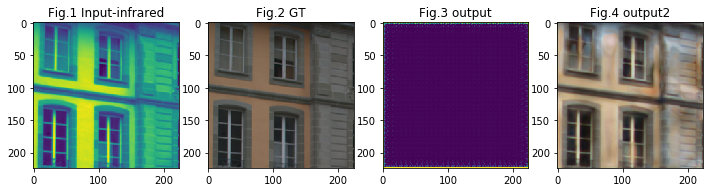

In [16]:


picI = Image.open('/home/kamata/linda/0508/dataset/nir/0064_nir.jpg')
picC = Image.open('/home/kamata/linda/0508/dataset/rgb/0064_rgb.jpg')
a=150
b=50
box=[a,b,a+224,b+224]
picI=picI.crop(box)
picC=picC.crop(box)

inn = t0(picI)
inn = inn[0:1,:,:]
inp = net2.g(Variable(inn.unsqueeze(0).cuda()))
inp,inp2 = net2(Variable(inn.unsqueeze(0).cuda()),inp)
pic = t0(picC)
#pic = pic.filter(ImageFilter.FIND_EDGES)
plt.figure('data', figsize=(12,4))
plt.subplot(1,4,1)
plt.title('Fig.1 Input-infrared')
imshow(picI)
plt.subplot(1,4,3)
plt.title('Fig.3 output')
inpc = inp.data.cpu().squeeze(0)
inpc = torch.clamp(inpc,0,1)
print inpc
imshow(t1(inpc))
plt.subplot(1,4,2)
plt.title('Fig.2 GT')
imshow(t1(pic))
plt.subplot(1,4,4)
plt.title('Fig.4 output2')
inpc = inp2.data.cpu().squeeze(0)
inpc = torch.clamp(inpc,0,1)
inpc = t1(inpc)
imshow(inpc)

pic_name = '/home/kamata/linda/0508/dloss3/o-o2.jpg'
inpc.save(pic_name)